
# Chapter 13

# Lab: Multiple Testing
 

We include our usual imports seen in earlier labs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data


We also collect the new imports
needed for this lab.

In [2]:
from scipy.stats import \
    (ttest_1samp,
     ttest_rel,
     ttest_ind,
     t as t_dbn)
from statsmodels.stats.multicomp import \
     pairwise_tukeyhsd
from statsmodels.stats.multitest import \
     multipletests as mult_test


## Review of Hypothesis Tests
We begin by performing some one-sample $t$-tests.

First we create 100 variables, each consisting of 10 observations. The
first 50 variables have mean $0.5$ and variance $1$, while the others
have mean $0$ and variance $1$.

In [3]:
rng = np.random.default_rng(12)
X = rng.standard_normal((10, 100))
true_mean = np.array([0.5]*50 + [0]*50)
X += true_mean[None,:]


To begin, we use `ttest_1samp()`  from the
`scipy.stats` module to test $H_{0}: \mu_1=0$, the null
hypothesis that the first variable has mean zero.

In [4]:
result = ttest_1samp(X[:,0], 0)
result.pvalue


0.9307442156164141

The $p$-value comes out to 0.931, which is not low enough to
reject the null hypothesis at level $\alpha=0.05$.  In this case,
$\mu_1=0.5$, so the null hypothesis is false. Therefore, we have made
a Type II error by failing to reject the null hypothesis when the null
hypothesis is false. 

We now test $H_{0,j}: \mu_j=0$ for $j=1,\ldots,100$. We compute the
100 $p$-values, and then construct a vector recording whether the
$j$th $p$-value is less than or equal to 0.05, in which case we reject
$H_{0j}$, or greater than 0.05, in which case we do not reject
$H_{0j}$, for $j=1,\ldots,100$.

In [5]:
p_values = np.empty(100)
for i in range(100):
   p_values[i] = ttest_1samp(X[:,i], 0).pvalue
decision = pd.cut(p_values,
                  [0, 0.05, 1],
                  labels=['Reject H0',
                          'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                       categories=[True, False],
                       ordered=True)


Since this is a simulated data set, we can create a $2 \times 2$ table
similar to  Table 13.2.

In [6]:
pd.crosstab(decision,
            truth,
     rownames=['Decision'],
     colnames=['H0'])


H0,True,False
Decision,,
Reject H0,5,15
Do not reject H0,45,35


Therefore, at level $\alpha=0.05$, we reject 15 of the 50 false
null hypotheses, and we incorrectly reject 5 of the true null
hypotheses. Using the notation from Section 13.3, we have
$V=5$, $S=15$, $U=45$ and $W=35$.
We have set $\alpha=0.05$, which means that we expect to reject around
5% of the true null hypotheses. This is in line with the $2 \times 2$
table above, which indicates that we rejected $V=5$ of the $50$ true
null hypotheses.

In the simulation above, for the false null hypotheses, the ratio of
the mean to the standard deviation was only $0.5/1 = 0.5$. This
amounts to quite a weak signal, and it resulted in a high number of
Type II errors.  Let’s instead simulate data with a stronger signal,
so that the ratio of the mean to the standard deviation for the false
null hypotheses equals $1$. We make only 10 Type II errors.


In [7]:
true_mean = np.array([1]*50 + [0]*50)
X = rng.standard_normal((10, 100))
X += true_mean[None,:]
for i in range(100):
   p_values[i] = ttest_1samp(X[:,i], 0).pvalue
decision = pd.cut(p_values,
                  [0, 0.05, 1],
                  labels=['Reject H0',
                          'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                       categories=[True, False],
                       ordered=True)
pd.crosstab(decision,
            truth,
            rownames=['Decision'],
            colnames=['H0'])


H0,True,False
Decision,,
Reject H0,2,40
Do not reject H0,48,10


## Family-Wise Error Rate
Recall from  (13.5)  that if the null hypothesis is true
for each of $m$ independent hypothesis tests, then the FWER is equal
to $1-(1-\alpha)^m$. We can use this expression to compute the FWER
for $m=1,\ldots, 500$ and $\alpha=0.05$, $0.01$, and $0.001$.
We plot the FWER for these values of $\alpha$ in order to
reproduce  Figure 13.2.

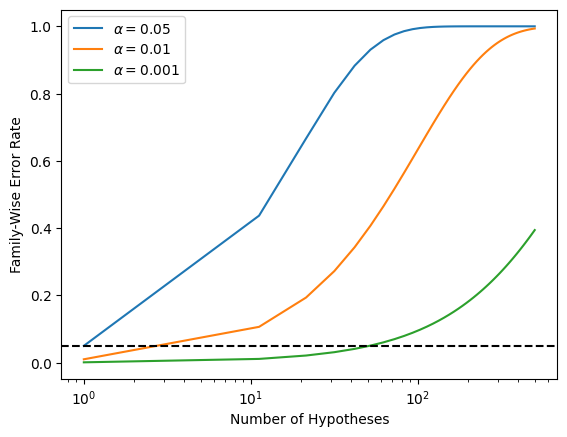

In [8]:
m = np.linspace(1, 501)
fig, ax = plt.subplots()
[ax.plot(m,
         1 - (1 - alpha)**m,
         label=r'$\alpha=%s$' % str(alpha))
         for alpha in [0.05, 0.01, 0.001]]
ax.set_xscale('log')
ax.set_xlabel('Number of Hypotheses')
ax.set_ylabel('Family-Wise Error Rate')
ax.legend()
ax.axhline(0.05, c='k', ls='--');


As discussed previously, even for moderate values of $m$ such as $50$,
the FWER exceeds $0.05$ unless $\alpha$ is set to a very low value,
such as $0.001$.  Of course, the problem with setting $\alpha$ to such
a low value is that we are likely to make a number of Type II errors:
in other words, our power is very low.

We now conduct a one-sample $t$-test for each of the first five
managers in the  
`Fund`   dataset, in order to test the null
hypothesis that the $j$th fund manager’s mean return equals zero,
$H_{0,j}: \mu_j=0$.

In [9]:
Fund = load_data('Fund')
fund_mini = Fund.iloc[:,:5]
fund_mini_pvals = np.empty(5)
for i in range(5):
    fund_mini_pvals[i] = ttest_1samp(fund_mini.iloc[:,i], 0).pvalue
fund_mini_pvals


array([0.00620236, 0.91827115, 0.01160098, 0.6005396 , 0.75578151])

In [32]:
Fund

,Manager1,Manager2,Manager3,Manager4,Manager5,Manager6,Manager7,Manager8,Manager9,Manager10,...,Manager1991,Manager1992,Manager1993,Manager1994,Manager1995,Manager1996,Manager1997,Manager1998,Manager1999,Manager2000
0,-3.341992,-4.167469,9.389223,8.417220,0.997863,7.191473,-10.767592,4.072425,1.575264,-0.798505,...,-2.948706,10.350706,-2.855337,-4.431786,0.739544,0.198044,1.752188,-1.534710,-3.359419,6.585654
1,3.759627,12.525254,3.403366,0.143944,-7.222227,0.067747,-10.737053,-1.138185,-7.166604,4.778522,...,24.003150,-1.966606,-1.609109,1.405325,4.717175,1.540359,-12.218233,-0.073008,-8.547683,-2.382629
2,12.970091,-2.581061,-0.824734,6.584604,17.050241,1.857130,3.196942,-7.981362,-1.214148,2.338250,...,-2.926914,6.420147,8.946921,3.449013,1.009957,1.481369,14.203314,0.005562,-5.105035,2.292429
3,-4.874630,7.981743,-4.026743,-4.731946,0.503276,0.740187,-28.969410,4.683751,-0.568840,-4.000547,...,-3.112208,3.173581,-6.017109,-1.984873,1.022525,-2.261927,19.345970,-1.048299,-0.016154,1.196832
4,2.019279,-5.370236,-4.854669,10.594432,-6.891574,9.877838,1.430033,9.840311,5.311455,18.365094,...,7.173653,-9.157211,7.643125,-1.022339,-1.325865,2.848785,-6.642081,2.488612,0.032060,-7.510032
5,3.415439,-10.647755,16.549797,-8.334291,1.533509,7.050939,2.107857,3.701138,1.490086,2.199025,...,5.792461,0.537672,-12.371356,1.930667,-3.917686,-0.242861,6.762622,-0.137823,10.510394,2.984115
6,7.193738,-1.205938,8.399702,6.896294,-1.621761,0.864912,-4.810192,-11.752909,-0.129961,0.133403,...,10.891581,-3.865650,12.466727,-0.595052,4.933741,-1.071350,7.485861,0.974756,-2.400597,-2.840203
7,0.972538,6.028601,16.260359,4.720996,-3.048315,1.010849,3.624965,-0.036639,-6.226722,22.694019,...,12.814508,-1.738497,-3.414952,1.191849,2.888126,-0.209876,-4.792800,1.695807,-0.356199,10.418316
8,15.573899,7.197357,-1.612454,3.303660,2.878793,10.954139,7.344508,-0.686409,6.323397,10.400917,...,-11.592087,-9.432885,6.534249,0.396498,-4.783514,-1.715485,-10.020975,1.117535,-4.636334,0.508280
9,1.635003,10.257006,-1.093647,6.189697,0.581663,1.904792,-14.983875,-4.724890,2.328727,6.331790,...,-14.122046,1.501691,-0.922836,3.196658,0.023192,-1.446785,5.761304,-1.883687,-0.718631,7.474730


The $p$-values are low for Managers One and Three, and high for the
other three managers.  However, we cannot simply reject $H_{0,1}$ and
$H_{0,3}$, since this would fail to account for the multiple testing
that we have performed. Instead, we will conduct Bonferroni’s method
and Holm’s method to control the FWER.

To do this, we use the `multipletests()`  function from the
`statsmodels` module (abbreviated to `mult_test()`). Given the $p$-values,
for methods like Holm and Bonferroni the function outputs
adjusted $p$-values,  which§
can be thought of as a new set of $p$-values that have been corrected
for multiple testing. If the adjusted $p$-value for a given hypothesis
is less than or equal to $\alpha$, then that hypothesis can be
rejected while maintaining a FWER of no more than $\alpha$. In other
words, for such methods, the adjusted $p$-values resulting from the `multipletests()`
function can simply be compared to the desired FWER in order to
determine whether or not to reject each hypothesis. We will later
see that we can use the same function to control FDR as well.

The `mult_test()` function takes $p$-values and a `method` argument, as well as an optional
`alpha` argument. It returns the  decisions (`reject` below)
as well as the adjusted $p$-values (`bonf`).

In [10]:
reject, bonf = mult_test(fund_mini_pvals, method = "bonferroni")[:2]
reject


array([ True, False, False, False, False])

The $p$-values `bonf` are simply the `fund_mini_pvalues` multiplied by 5 and truncated to be less than
or equal to 1.

In [11]:
bonf, np.minimum(fund_mini_pvals * 5, 1)


(array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ]),
 array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ]))

Therefore, using Bonferroni’s method, we are able to reject the null hypothesis only for Manager
One while controlling FWER at $0.05$.

By contrast, using Holm’s method, the adjusted $p$-values indicate
that we can  reject the null
hypotheses for Managers One and Three at a FWER of $0.05$.

In [12]:
mult_test(fund_mini_pvals, method = "holm", alpha=0.05)[:2]


(array([ True, False,  True, False, False]),
 array([0.03101178, 1.        , 0.04640393, 1.        , 1.        ]))

As discussed previously, Manager One seems to perform particularly
well, whereas Manager Two has poor performance.

In [13]:
fund_mini.mean()


Manager1    3.0
Manager2   -0.1
Manager3    2.8
Manager4    0.5
Manager5    0.3
dtype: float64

Is there evidence of a meaningful difference in performance between
these two managers?  We can check this by performing a  paired $t$-test  using the `ttest_rel()` function
from `scipy.stats`:

In [14]:
ttest_rel(fund_mini['Manager1'],
          fund_mini['Manager2']).pvalue


0.038391072368079586

The test results in a $p$-value of 0.038,
suggesting a statistically significant difference.

However, we decided to perform this test only after examining the data
and noting that Managers One and Two had the highest and lowest mean
performances.  In a sense, this means that we have implicitly
performed ${5 \choose 2} = 5(5-1)/2=10$ hypothesis tests, rather than
just one, as discussed in  Section 13.3.2.  Hence, we use the
`pairwise_tukeyhsd()`  function from
`statsmodels.stats.multicomp` to apply Tukey’s method
  in order to adjust for multiple testing.  This function takes
as input a fitted *ANOVA*  regression model, which is
essentially just a linear regression in which all of the predictors
are qualitative.  In this case, the response consists of the monthly
excess returns achieved by each manager, and the predictor indicates
the manager to which each return corresponds.

In [15]:
returns = np.hstack([fund_mini.iloc[:,i] for i in range(5)])
managers = np.hstack([[i+1]*50 for i in range(5)])
tukey = pairwise_tukeyhsd(returns, managers)
print(tukey.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2     -3.1 0.1862 -6.9865 0.7865  False
     1      3     -0.2 0.9999 -4.0865 3.6865  False
     1      4     -2.5 0.3948 -6.3865 1.3865  False
     1      5     -2.7 0.3152 -6.5865 1.1865  False
     2      3      2.9 0.2453 -0.9865 6.7865  False
     2      4      0.6 0.9932 -3.2865 4.4865  False
     2      5      0.4 0.9986 -3.4865 4.2865  False
     3      4     -2.3  0.482 -6.1865 1.5865  False
     3      5     -2.5 0.3948 -6.3865 1.3865  False
     4      5     -0.2 0.9999 -4.0865 3.6865  False
---------------------------------------------------


The `pairwise_tukeyhsd()` function provides confidence intervals
for the difference between each pair of managers (`lower` and
`upper`), as well as a $p$-value. All of these quantities have
been adjusted for multiple testing. Notice that the $p$-value for the
difference between Managers One and Two has increased from $0.038$ to
$0.186$, so there is no longer clear evidence of a difference between
the managers’ performances.  We can plot the confidence intervals for
the pairwise comparisons using the `plot_simultaneous()` method
of `tukey`. Any pair of intervals that don’t overlap indicates a significant difference at the nominal level of 0.05. In this case,
no differences are considered significant as reported in the table above.

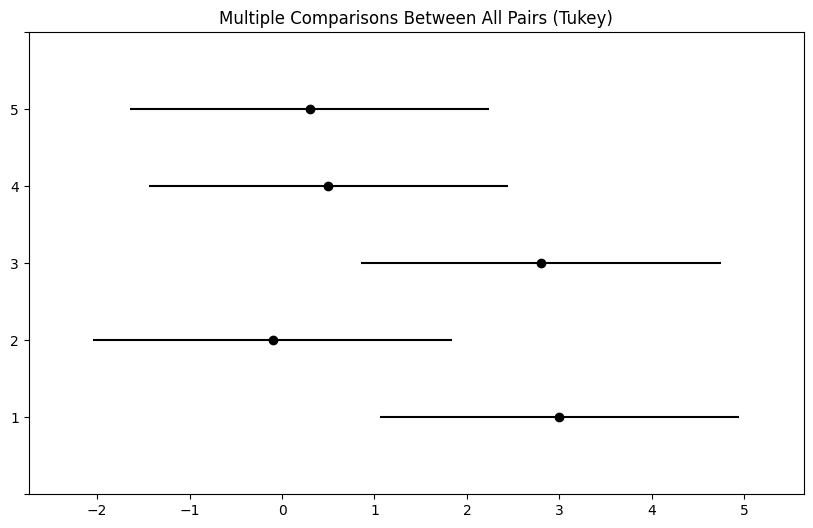

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
tukey.plot_simultaneous(ax=ax);


## False Discovery Rate
Now we perform hypothesis tests for all 2,000 fund managers in the
`Fund`  dataset. We perform a one-sample $t$-test
of   $H_{0,j}: \mu_j=0$, which states that the
$j$th fund manager’s mean return is zero.

In [17]:
fund_pvalues = np.empty(2000)
for i, manager in enumerate(Fund.columns):
    fund_pvalues[i] = ttest_1samp(Fund[manager], 0).pvalue


There are far too many managers to consider trying to control the FWER.
Instead, we focus on controlling the FDR: that is, the expected fraction of rejected null hypotheses that are actually false positives.
The `multipletests()` function (abbreviated `mult_test()`) can be used to carry out the Benjamini--Hochberg procedure.

In [18]:
fund_qvalues = mult_test(fund_pvalues, method = "fdr_bh")[1]
fund_qvalues[:10]


array([0.08988921, 0.991491  , 0.12211561, 0.92342997, 0.95603587,
       0.07513802, 0.0767015 , 0.07513802, 0.07513802, 0.07513802])

The  *q-values* output by the
Benjamini--Hochberg procedure can be interpreted as the smallest FDR
threshold at which we would reject a particular null hypothesis. For
instance, a $q$-value of $0.1$ indicates that we can reject the
corresponding null hypothesis at an FDR of 10% or greater, but that
we cannot reject the null hypothesis at an FDR below 10%.

If we control the FDR at 10%, then for how many of the fund managers can we reject $H_{0,j}: \mu_j=0$?

In [19]:
(fund_qvalues <= 0.1).sum()


146

We find that 146 of the 2,000 fund managers have a $q$-value below
0.1; therefore, we are able to conclude that 146 of the fund managers
beat the market at an FDR of 10%.  Only about 15 (10% of 146) of
these fund managers are likely to be false discoveries.

By contrast, if we had instead used Bonferroni’s method to control the
FWER at level $\alpha=0.1$, then we would have failed to reject any
null hypotheses!

In [20]:
(fund_pvalues <= 0.1 / 2000).sum()


0

Figure 13.6 displays the ordered
$p$-values, $p_{(1)} \leq p_{(2)} \leq \cdots \leq p_{(2000)}$, for
the  `Fund`  dataset, as well as the threshold for rejection by the
Benjamini--Hochberg procedure.  Recall that the Benjamini--Hochberg
procedure identifies the largest $p$-value such that $p_{(j)}<qj/m$,
and rejects all hypotheses for which the $p$-value is less than or
equal to $p_{(j)}$. In the code below, we implement the
Benjamini--Hochberg procedure ourselves, in order to illustrate how it
works. We first order the $p$-values. We then identify all $p$-values
that satisfy $p_{(j)}<qj/m$ (`sorted_set_`).  Finally, `selected_`
is a boolean array indicating which $p$-values
 are less than or equal to the largest
$p$-value in `sorted_[sorted_set_]`. Therefore, `selected_` indexes the
$p$-values rejected by the Benjamini--Hochberg procedure.

In [37]:
sorted_ = np.sort(fund_pvalues)
m = fund_pvalues.shape[0]
q = 0.1
sorted_set_ = np.where(sorted_ < q * np.linspace(1, m, m) / m)[0] # returns array with indices of sorted_ array where condition is met
# first this satisfies condition only between indexes 51 - 145
# but below we then reject also idices below 51, so that is why everything is red (rejected) in the graph below up until 146

if sorted_set_.shape[0] > 0:
    selected_ = fund_pvalues < sorted_[sorted_set_].max()
    sorted_set_ = np.arange(sorted_set_.max())
else:
    selected_ = []
    sorted_set_ = []

len(sorted_[sorted_set_]), len(sorted_set_)


(145, 145)

We now reproduce  the middle panel of Figure 13.6.

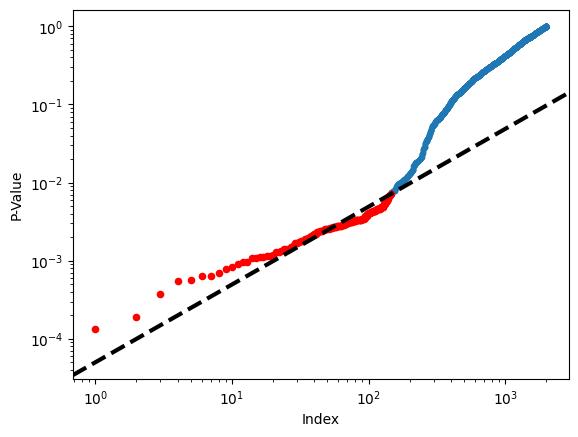

In [22]:
fig, ax = plt.subplots()
ax.scatter(np.arange(0, sorted_.shape[0]) + 1,
           sorted_, s=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('P-Value')
ax.set_xlabel('Index')
ax.scatter(sorted_set_+1, sorted_[sorted_set_], c='r', s=20)
ax.axline((0, 0), (1,q/m), c='k', ls='--', linewidth=3);


## A Re-Sampling Approach
Here, we implement the re-sampling approach to hypothesis testing
using the  `Khan`  dataset, which we investigated in
Section 13.5.  First, we merge the training and
testing data, which results in observations on 83 patients for
2,308 genes.

In [23]:
Khan = load_data('Khan')      
D = pd.concat([Khan['xtrain'], Khan['xtest']])
D['Y'] = pd.concat([Khan['ytrain'], Khan['ytest']])
D['Y'].value_counts()


2    29
4    25
3    18
1    11
Name: Y, dtype: int64

In [40]:
Khan['xtest']

,G0001,G0002,G0003,G0004,G0005,G0006,G0007,G0008,G0009,G0010,...,G2299,G2300,G2301,G2302,G2303,G2304,G2305,G2306,G2307,V2308
0,0.139501,-1.168927,0.564973,-3.366796,-1.323132,-0.692547,2.327395,0.923703,0.112167,0.509765,...,-0.180803,-0.942635,-1.210662,-0.588787,-0.070422,-2.783852,-2.840439,-1.160913,-0.343054,-0.055513
1,1.164275,-2.018158,1.103533,-2.165435,-1.440117,-0.437420,2.661587,1.224011,0.210504,1.045563,...,-0.709480,-1.532940,-2.385967,-0.389641,0.422781,-2.816750,-2.422495,-1.722607,-1.703749,-1.699910
2,0.841093,0.254720,-0.208748,-2.148149,-1.512765,-1.263723,2.946642,0.087828,0.482920,1.063020,...,-0.067958,-1.854060,-1.541312,-1.773723,-1.879935,-2.265289,-2.405726,-0.176379,-0.128743,-0.996417
3,0.685065,-1.927579,-0.233068,-1.640413,-1.008954,0.774451,1.617168,-0.567925,0.036621,-0.101701,...,1.077559,-0.263966,-1.966113,-1.086190,0.885914,-0.248590,0.385874,-0.508163,-0.626985,-0.699366
4,-1.956163,-2.234926,0.281563,-2.695628,-1.214697,-1.059872,2.498070,0.780196,1.041583,0.727500,...,-1.209320,-0.693147,-1.846427,-0.993442,-3.294138,-3.332605,-2.282782,-0.656622,-2.012157,-1.668657
5,-0.258641,-1.684700,0.175800,-2.323809,-1.692276,-0.008637,2.302135,0.455778,-0.342490,0.716522,...,-2.049494,-1.223835,-1.140372,-0.952436,0.294012,-1.205307,-1.457576,-0.655081,-0.060493,-0.980563
6,-1.109875,-1.046969,-0.853786,-2.607752,-1.770781,-1.259133,1.426380,-0.743599,0.613129,-0.533071,...,-0.963120,-1.016940,-0.991553,-0.643405,-2.323809,-1.435485,-0.484995,0.479335,-1.006489,-0.778487
7,1.471485,-1.751578,-0.256700,-1.899122,-1.364924,-1.198654,2.489878,-0.035006,0.833474,0.779279,...,-0.000900,-1.020263,-1.599488,-2.273998,-0.559141,-1.985587,-1.044124,-1.064211,-1.179605,-0.499556
8,-0.396159,-1.191386,0.696691,-1.862397,-1.312672,0.744980,1.762708,1.034038,0.802943,0.953471,...,-1.104429,-0.955811,-0.438505,-0.845366,-0.372659,0.059118,-1.209320,-0.220148,0.452031,-1.119325
9,-2.136224,-2.236797,-0.946492,-2.777400,-1.822631,-0.455233,2.547514,-0.270366,1.437866,0.543777,...,-1.552585,-0.649513,-1.159318,-0.809456,-2.993734,-2.431555,-0.589148,-0.790319,-0.536485,-1.935168


In [38]:
D

,G0001,G0002,G0003,G0004,G0005,G0006,G0007,G0008,G0009,G0010,...,G2300,G2301,G2302,G2303,G2304,G2305,G2306,G2307,V2308,Y
0,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,0.565427,...,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172,2
1,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,0.159053,...,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395,2
2,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,0.496585,...,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434,2
3,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,0.994732,...,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483,2
4,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,0.278313,...,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.648725,-1.386694,-0.562645,-2.006191,-1.098112,0.944645,1.994564,0.295873,0.560986,0.342809,...,-0.543693,-1.868857,-1.135069,-0.991284,-1.053543,-1.175709,-1.334841,-0.511826,-1.323132,2
16,-0.271415,-1.125470,-1.538048,-2.649310,-1.148538,-0.355390,1.811693,0.344440,0.339895,1.169443,...,-1.137873,-0.962073,-0.592036,-1.977607,-1.232715,-1.881903,0.061283,0.556926,-0.835402,4
17,-0.445818,-1.380312,0.299289,-2.739541,-1.468807,0.991658,2.057784,0.295055,0.766955,0.466309,...,-1.763172,-0.375421,-1.492099,-0.467287,-0.982965,-0.991284,0.209612,-0.194313,-1.136626,3
18,0.259437,-0.782634,-1.277978,-1.889813,-0.659132,0.587620,1.427556,-0.237877,-0.007327,0.003793,...,-0.869169,-1.705398,-0.854255,-1.893128,-1.461880,-1.702650,-1.393520,-1.011976,-1.160913,4


There are four classes of cancer. For each gene, we compare the mean
expression in the second class (rhabdomyosarcoma) to the mean
expression in the fourth class (Burkitt’s lymphoma).  Performing a
standard two-sample $t$-test  
using `ttest_ind()`  from `scipy.stats` on the $11$th
gene produces a test-statistic of -2.09 and an associated $p$-value
of 0.0412, suggesting modest evidence of a difference in mean
expression levels between the two cancer types.

In [24]:
D2 = D[lambda df:df['Y'] == 2]
D4 = D[lambda df:df['Y'] == 4]
gene_11 = 'G0011'
observedT, pvalue = ttest_ind(D2[gene_11],
                              D4[gene_11],
                              equal_var=True)
observedT, pvalue


(-2.0936330736768185, 0.04118643782678394)

However, this $p$-value relies on the assumption that under the null
hypothesis of no difference between the two groups, the test statistic
follows a $t$-distribution with $29+25-2=52$ degrees of freedom.
Instead of using this theoretical null distribution, we can randomly
split the 54 patients into two groups of 29 and 25, and compute a new
test statistic.  Under the null hypothesis of no difference between
the groups, this new test statistic should have the same distribution
as our original one.  Repeating this process 10,000 times allows us to
approximate the null distribution of the test statistic.  We compute
the fraction of the time that our observed test statistic exceeds the
test statistics obtained via re-sampling.

In [25]:
B = 10000
Tnull = np.empty(B)
D_ = np.hstack([D2[gene_11], D4[gene_11]])
n_ = D2[gene_11].shape[0]
D_null = D_.copy()
for b in range(B):
    rng.shuffle(D_null)
    ttest_ = ttest_ind(D_null[:n_],
                       D_null[n_:],
                       equal_var=True)
    Tnull[b] = ttest_.statistic
(np.abs(Tnull) > np.abs(observedT)).mean()


0.0398

This fraction, 0.0398,
is our re-sampling-based $p$-value.
It is almost identical to the $p$-value of  0.0412 obtained using the theoretical null distribution.
We can plot  a histogram of the re-sampling-based test statistics in order to reproduce  Figure 13.7.

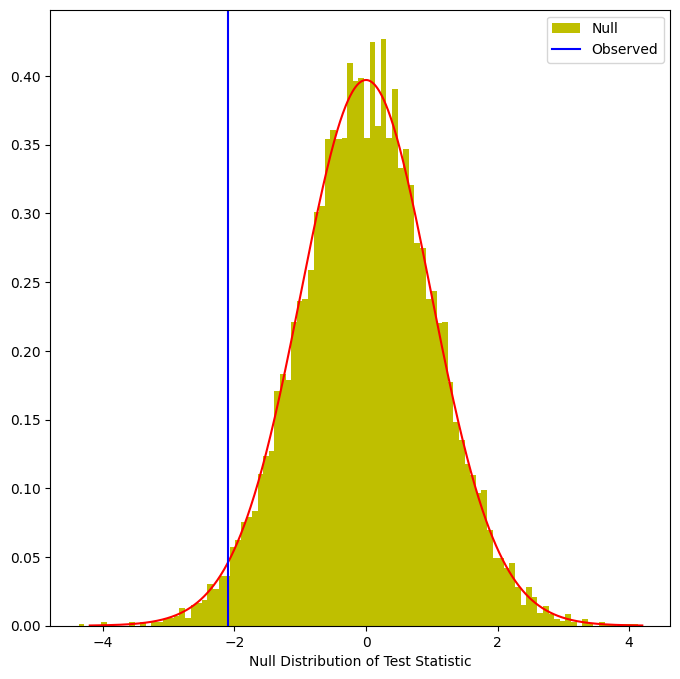

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(Tnull,
        bins=100,
        density=True,
        facecolor='y',
        label='Null')
xval = np.linspace(-4.2, 4.2, 1001)
ax.plot(xval,
        t_dbn.pdf(xval, D_.shape[0]-2),
        c='r')
ax.axvline(observedT,
           c='b',
           label='Observed')
ax.legend()
ax.set_xlabel("Null Distribution of Test Statistic");


The re-sampling-based null distribution is almost identical to the theoretical null distribution, which is displayed in red.

Finally, we implement the plug-in re-sampling FDR approach outlined in
Algorithm 13.4. Depending on the speed of your
computer, calculating the FDR for all 2,308 genes in the `Khan`
dataset may take a while.  Hence, we will illustrate the approach on a
random subset of 100 genes.  For each gene, we first compute the
observed test statistic, and then produce 10,000 re-sampled test
statistics. This may take a few minutes to run.  If you are in a rush,
then you could set `B` equal to a smaller value (e.g. `B=500`).

In [27]:
m, B = 100, 10000
idx = rng.choice(Khan['xtest'].columns, m, replace=False)
T_vals = np.empty(m)
Tnull_vals = np.empty((m, B))

for j in range(m):
    col = idx[j]
    T_vals[j] = ttest_ind(D2[col],
                          D4[col],
                          equal_var=True).statistic
    D_ = np.hstack([D2[col], D4[col]])
    D_null = D_.copy()
    for b in range(B):
        rng.shuffle(D_null)
        ttest_ = ttest_ind(D_null[:n_],
                           D_null[n_:],
                           equal_var=True)
        Tnull_vals[j,b] = ttest_.statistic


Next, we compute the number of rejected null hypotheses $R$, the
estimated number of false positives $\widehat{V}$, and the estimated
FDR, for a range of threshold values $c$ in
Algorithm 13.4. The threshold values are chosen
using the absolute values of the test statistics from the 100 genes.

In [28]:
cutoffs = np.sort(np.abs(T_vals))
FDRs, Rs, Vs = np.empty((3, m))
for j in range(m):
   R = np.sum(np.abs(T_vals) >= cutoffs[j])
   V = np.sum(np.abs(Tnull_vals) >= cutoffs[j]) / B
   Rs[j] = R
   Vs[j] = V
   FDRs[j] = V / R


In [47]:
np.abs(T_vals) >= cutoffs[FDRs < 0.1].min()

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True, False, False, False,  True, False, False,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True, False, False,  True, False, False, False,
       False])

Now, for any given FDR, we can find the genes that will be
rejected. For example, with FDR controlled at 0.1, we reject 15 of the
100 null hypotheses. On average, we would expect about one or two of
these genes (i.e. 10% of 15) to be false discoveries.  At an FDR of
0.2, we can reject the null hypothesis for 28 genes, of which we
expect around six to be false discoveries.

The variable `idx` stores which
genes were included in our 100 randomly-selected genes. Let’s look at
the genes whose estimated FDR is less than 0.1.

In [29]:
sorted(idx[np.abs(T_vals) >= cutoffs[FDRs < 0.1].min()])


['G0097',
 'G0129',
 'G0182',
 'G0714',
 'G0812',
 'G0941',
 'G0982',
 'G1020',
 'G1022',
 'G1090',
 'G1320',
 'G1634',
 'G1697',
 'G1853',
 'G1854',
 'G1994',
 'G2017',
 'G2115',
 'G2193']

At an FDR threshold of 0.2, more genes are selected, at the cost of having a higher expected
proportion of false discoveries.

In [30]:
sorted(idx[np.abs(T_vals) >= cutoffs[FDRs < 0.2].min()])


['G0097',
 'G0129',
 'G0158',
 'G0182',
 'G0242',
 'G0552',
 'G0679',
 'G0714',
 'G0751',
 'G0812',
 'G0908',
 'G0941',
 'G0982',
 'G1020',
 'G1022',
 'G1090',
 'G1240',
 'G1244',
 'G1320',
 'G1381',
 'G1514',
 'G1634',
 'G1697',
 'G1768',
 'G1853',
 'G1854',
 'G1907',
 'G1994',
 'G2017',
 'G2115',
 'G2193']

The next line  generates  Figure 13.11, which is similar
to  Figure 13.9,
except that it is based on only  a subset of the genes.

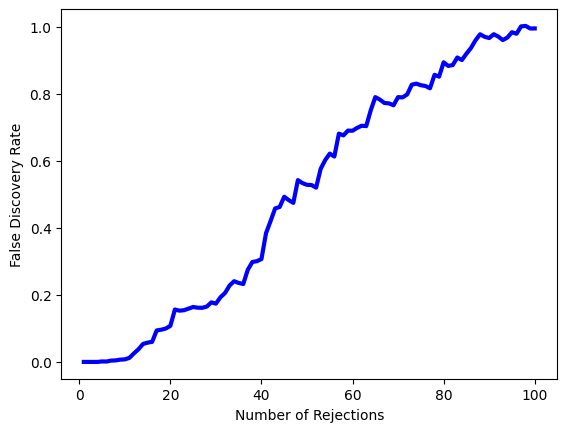

In [31]:
fig, ax = plt.subplots()
ax.plot(Rs, FDRs, 'b', linewidth=3)
ax.set_xlabel("Number of Rejections")
ax.set_ylabel("False Discovery Rate");
